In [1]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.16.1'

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [7]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [8]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
46/46 [==============================] - 29s 626ms/step - loss: 0.8158 - accuracy: 0.7264 - val_loss: 0.5231 - val_accuracy: 0.8331
Epoch 2/10
46/46 [==============================] - 9s 200ms/step - loss: 0.3332 - accuracy: 0.8850 - val_loss: 0.4228 - val_accuracy: 0.8687
Epoch 3/10
46/46 [==============================] - 9s 201ms/step - loss: 0.1894 - accuracy: 0.9394 - val_loss: 0.4422 - val_accuracy: 0.8687
Epoch 4/10
46/46 [==============================] - 9s 194ms/step - loss: 0.1358 - accuracy: 0.9513 - val_loss: 0.4898 - val_accuracy: 0.8536
Epoch 5/10
46/46 [==============================] - 9s 201ms/step - loss: 0.0877 - accuracy: 0.9718 - val_loss: 0.4566 - val_accuracy: 0.8714
Epoch 6/10
46/46 [==============================] - 10s 214ms/step - loss: 0.0565 - accuracy: 0.9833 - val_loss: 0.4589 - val_accuracy: 0.8700
Epoch 7/10
46/46 [==============================] - 9s 204ms/step - loss: 0.0418 - accuracy: 0.9895 - val_loss: 0.4902 - val_accuracy: 0.8728
Epoc

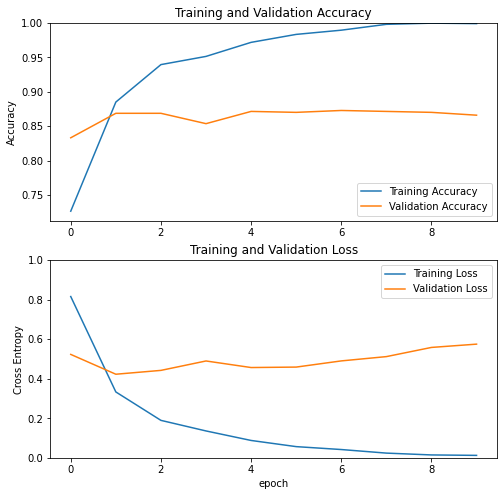

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [16]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=10, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/10
46/46 [==============================] - 9s 204ms/step - loss: 0.0573 - accuracy: 0.9830 - val_loss: 0.6002 - val_accuracy: 0.8659
Epoch 2/10
46/46 [==============================] - 9s 200ms/step - loss: 0.0510 - accuracy: 0.9874 - val_loss: 0.5911 - val_accuracy: 0.8714
Epoch 3/10
46/46 [==============================] - 9s 198ms/step - loss: 0.0524 - accuracy: 0.9867 - val_loss: 0.5855 - val_accuracy: 0.8728
Epoch 4/10
46/46 [==============================] - 9s 200ms/step - loss: 0.0392 - accuracy: 0.9898 - val_loss: 0.5647 - val_accuracy: 0.8755
Epoch 5/10
46/46 [==============================] - 9s 196ms/step - loss: 0.0324 - accuracy: 0.9929 - val_loss: 0.5618 - val_accuracy: 0.8769
Epoch 6/10
46/46 [==============================] - 9s 198ms/step - loss: 0.0247 - accuracy: 0.9966 - val_loss: 0.5552 - val_accuracy: 0.8769
Epoch 7/10
46/46 [==============================] - 9s 199ms/step - loss: 0.0213 - accuracy: 0.9976 - val_loss: 0.5459 - val_accuracy: 0.8796
Epoch 

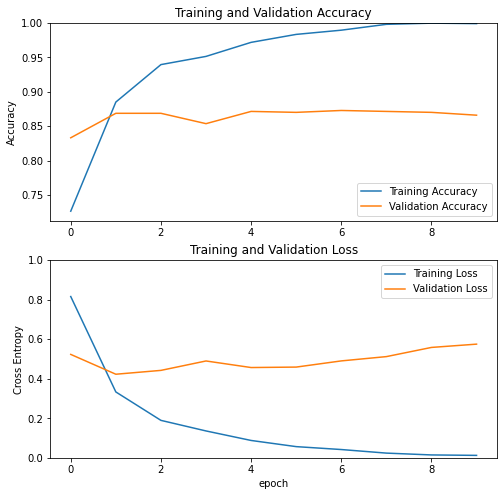

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning\assets


In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('save/fine_tuning/assets/model.tflite', 'wb') as f:
  f.write(tflite_model)